In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

### Download the Campy genome

Here we use Biopython to download the campy genome and save as file campy.fa

In [3]:
from Bio import Entrez, SeqIO

In [ ]:
Entrez.email = "hcorrada@gmail.com"
handle = Entrez.efetch(db="nucleotide", id="AL111168.1", rettype="gb", retmode="text")
record = SeqIO.read(handle, "genbank")
handle.close()

SeqIO.write(record, "campy.fa", "fasta")

### Calculate skew for campylobacter

This function computes skew

In [4]:
def get_skew_vec(genome):
    res = [0]
    skew = 0
    for i in xrange(len(genome)):
        c = genome[i]

        if c == 'C':
            skew = skew - 1
        elif c == 'G':
            skew = skew + 1
        res.append(skew)
    return res

Now compute the skew for campy and plot it.

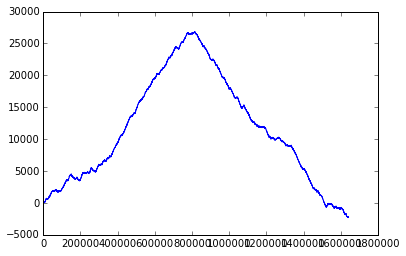

In [5]:
record = SeqIO.read("campy.fa", "fasta")
skew_vec = get_skew_vec(record)
plt.plot(skew_vec)

It looks like the minimum skew is at the end of the file, which suggests that oriC is around the beginning of the file. So let's take the last 250bp followed by the first 250bp as the candidate oriC region.

In [6]:
candidate_region = record[-250:] + record[:250]
len(candidate_region)

500

### Find frequent words

This code finds frequent words with mismatches and reverse complement

In [7]:
from collections import defaultdict

# use this hash table to get complementary nucleotides
complement = dict(A="T", C="G", G="C", T="A")

# compute the reverse complement of a given string
# input:
#  text: a string
# output:
#  the reverse complement of text
def revcomp(text):
    # turn the string into a list
    out = list(text)

    # reverse the list (in place)
    out.reverse()

    # get complement at each position of list
    for i in xrange(len(out)):
        out[i] = complement[out[i]]

    # turn back into string and return
    return ''.join(out)

# generate the d neighborhood of a DNA string
nucleotides = list('ACGT')

def get_neighbors(pattern, d):
    if d == 0:
        return [(pattern,0)]
    if len(pattern) == 1:
        return [(nuc, 1 if nuc != pattern else 0) for nuc in nucleotides]

    neighborhood = set()
    suffix_neighbors = get_neighbors(pattern[1:], d)
    for (text, cur_d) in suffix_neighbors:
        if cur_d < d:
            for nuc in nucleotides:
                distance = cur_d + 1 if nuc != pattern[0] else cur_d
                neighborhood.add((nuc + text, distance))
        else:
            neighborhood.add((pattern[0] + text, d))
    return neighborhood

# compute most frequent words allowing d mismatches, including reverse complements
# input:
#   text: input string
#   k: k-mer length
#   d: maximum number of mismatches
def freq_words_mismatch_revcomp(text, k, d):
    kmer_counts = defaultdict(int)

    n = len(text)
    for i in xrange(n-k+1):
        kmer = text[slice(i,i+k)]
        neighbors = get_neighbors(kmer, d)
        for neighbor, _ in neighbors:
            kmer_counts[neighbor] += 1
        kmer = revcomp(kmer)
        neighbors = get_neighbors(kmer, d)
        for neighbor, _ in neighbors:
            kmer_counts[neighbor] += 1

    max_count = 0
    frequent_words = list()
    for kmer, count in kmer_counts.items():
        if count == max_count:
            frequent_words.append(kmer)
        if count > max_count:
            frequent_words = [kmer]
            max_count = count
    return frequent_words, max_count

Ok, now run this code for k=3,4,5,6,7,8 and 9, counting the number of frequent words and their number of occurences

In [8]:
kvec = range(3,10)
res = list()
for k in kvec:
    print "running k=", k
    freq_words, count = freq_words_mismatch_revcomp(candidate_region, k, 2)
    res.append((k, len(freq_words), count))

running k= 3
running k= 4
running k= 5
running k= 6
running k= 7
running k= 8
running k= 9


Let's make a pretty table to include in our report

In [9]:
# based on http://calebmadrigal.com/display-list-as-table-in-ipython-notebook/
class ResTable(list):
    def _repr_html_(self):
        html = ["<table>"]
        html.append("<th>k</th><th>num kmers</th><th>num occurrences</th>")
        for row in self:
            html.append("<tr>")
            for col in row:
                html.append("<td>{0}</td>".format(col))
            html.append("</tr>")
        html.append("</table>")
        return ''.join(html)
ResTable(res)

3,1,704
4,1,389
5,1,247
6,1,146
7,1,79
8,1,47
9,1,29


Looks like there is a single kmer that occurs most frequently. Let's see that kmer for k=7,8,9.

In [10]:
words_7, _ = freq_words_mismatch_revcomp(candidate_region, 7, 2)
words_8, _ = freq_words_mismatch_revcomp(candidate_region, 8, 2)
words_9, _ = freq_words_mismatch_revcomp(candidate_region, 9, 2)
print "k=7", words_7
print "k=8", words_8
print "k=9", words_9

k=7 ['TTTTTTT']
k=8 ['TTTTTTTT']
k=9 ['TTTTTTTTT']


Well, that's not very interesting. At this point, I would run with bigger k.

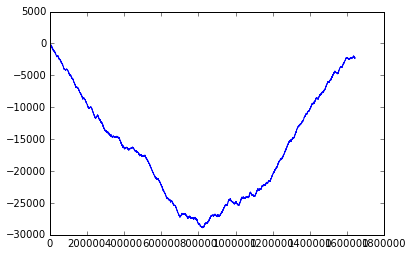

In [11]:
n = len(record)
rotated_seq = record[-n/2:] + record[:n/2]
rotated_skew = get_skew_vec(rotated_seq)
plt.plot(rotated_skew)

In [12]:
pos = sorted(range(len(rotated_skew)), key=lambda i: rotated_skew[i])[0]
print rotated_seq[pos-250:pos+251]

ID: AL111168.1
Name: AL111168.1
Description: AL111168.1 Campylobacter jejuni subsp. jejuni NCTC 11168 complete genome.
Number of features: 0
Seq('AAATTCAAGAAGAATTTTTCTTTATATTTAATGAAATCAAAAATAACGATGGAC...TTT', SingleLetterAlphabet())


In [13]:
rotated_candidate_region = rotated_seq[slice(pos-250,pos+250)]

kvec = range(3,10)
rotated_res = list()
for k in kvec:
    print "running k=", k
    freq_words, count = freq_words_mismatch_revcomp(rotated_candidate_region, k, 2)
    rotated_res.append((k, len(freq_words), count))

running k= 3
running k= 4
running k= 5
running k= 6
running k= 7
running k= 8
running k= 9


In [14]:
ResTable(rotated_res)

3,1,682
4,1,377
5,1,206
6,1,120
7,1,69
8,1,44
9,1,31


In [15]:
words_7, _ = freq_words_mismatch_revcomp(rotated_candidate_region, 7, 2)
words_8, _ = freq_words_mismatch_revcomp(rotated_candidate_region, 8, 2)
words_9, _ = freq_words_mismatch_revcomp(rotated_candidate_region, 9, 2)
print "k=7", words_7
print "k=8", words_8
print "k=9", words_9

k=7 ['TTTTTTT']
k=8 ['TTTTTTTT']
k=9 ['TTTTTTTTT']


In [16]:
# compute most frequent words allowing d mismatches, including reverse complements
# ignore kmers that have more than half of the string be homopolymer
#
# input:
#   text: input string
#   k: k-mer length
#   d: maximum number of mismatches
def is_homopolymer(kmer, factor):
    k = len(kmer)
    longest_homopolymer = -1
    cur_homopolymer = 0
    last_c = '$'
    for nuc in kmer:
        if nuc == last_c:
            cur_homopolymer += 1
        else:
            if cur_homopolymer > longest_homopolymer:
                longest_homopolymer = cur_homopolymer
            cur_homopolymer = 1
            last_c = nuc
    if cur_homopolymer > longest_homopolymer:
        longest_homopolymer = cur_homopolymer
    return longest_homopolymer >= factor

def freq_words_mismatch_revcomp_no_homopolymers(text, k, d, factor):
    kmer_counts = defaultdict(int)

    n = len(text)
    for i in xrange(n-k+1):
        kmer = text[slice(i,i+k)]
        neighbors = get_neighbors(kmer, d)
        for neighbor, _ in neighbors:
            if not is_homopolymer(neighbor, factor):
                kmer_counts[neighbor] += 1
        kmer = revcomp(kmer)
        neighbors = get_neighbors(kmer, d)
        for neighbor, _ in neighbors:
            if not is_homopolymer(neighbor, factor):
                kmer_counts[neighbor] += 1

    max_count = 0
    frequent_words = list()
    for kmer, count in kmer_counts.items():
        if count == max_count:
            frequent_words.append(kmer)
        if count > max_count:
            frequent_words = [kmer]
            max_count = count
    return frequent_words, max_count

In [19]:
is_homopolymer("TTTTT", 5)

True

In [23]:
kvec = range(3,10)
rotated_no_homopolymer_res = list()
for k in kvec:
    print "running k=", k
    freq_words, count = freq_words_mismatch_revcomp_no_homopolymers(rotated_candidate_region, k, 2, 4)
    rotated_no_homopolymer_res.append((k, len(freq_words), count))

running k= 3
running k= 4
running k= 5
running k= 6
running k= 7
running k= 8
running k= 9


In [24]:
ResTable(rotated_no_homopolymer_res)

3,1,682
4,1,377
5,1,198
6,1,106
7,1,60
8,1,27
9,1,16


In [25]:
words_9, _ = freq_words_mismatch_revcomp_no_homopolymers(rotated_candidate_region, 9, 2, 4)
print "k=9", words_9

k=9 ['TGATATCAT']


In [33]:
import heapq

def topn_words_mismatch_revcomp_no_homopolymers(text, k, d, factor, nslots):
    kmer_counts = defaultdict(int)

    n = len(text)
    for i in xrange(n-k+1):
        kmer = text[slice(i,i+k)]
        neighbors = get_neighbors(kmer, d)
        for neighbor, _ in neighbors:
            if not is_homopolymer(neighbor, factor):
                kmer_counts[neighbor] += 1
        kmer = revcomp(kmer)
        neighbors = get_neighbors(kmer, d)
        for neighbor, _ in neighbors:
            if not is_homopolymer(neighbor, factor):
                kmer_counts[neighbor] += 1

    heap = list()
    for kmer, count in kmer_counts.items():
        heapq.heappush(heap, (-count, kmer))
        
    res = list()
    slots_used = 0
    cur_entry = (0, [])
    while slots_used <= nslots:
        count, kmer = heapq.heappop(heap)
        if count != cur_entry[0]:
            res.append(cur_entry)
            cur_entry = (count, [kmer])
            slots_used += 1
        else:
            cur_entry[1].append(kmer)
            
    return res[1:]

In [35]:
words_9 = topn_words_mismatch_revcomp_no_homopolymers(rotated_candidate_region, 9, 2, 4, 3)
print "k=9", words_9

k=9 [(-16, ['TGATATCAT']), (-14, ['ATTTCTTTA', 'TATTTCTTT', 'TCTTTAATT', 'TTATATCTT']), (-13, ['ATGATATCT', 'GATATCATC', 'TGATTTCTT', 'TGTTATCTT', 'TTATATTAT'])]


In [41]:
import re
dnabox = re.compile("TTATC[CA]A[CA]A")
m = dnabox.match(str(record.seq))
print m


None


In [38]:
rotated_candidate_region.seq

Seq('AAATTCAAGAAGAATTTTTCTTTATATTTAATGAAATCAAAAATAACGATGGAC...ATT', SingleLetterAlphabet())